In [173]:
from cpclasses import *
data = np.load('dataset_for_exercise_62/nn_nnn_clusters_6.npz')

In [174]:
import torch
from torch_geometric.data import Data

def get_graph(index, cutoff=2.5, box_size=10):

    positions = data['positions'][index]
    positions = torch.vstack([torch.tensor(p,dtype=torch.float32) for p in positions])
    D = torch.cdist(positions, positions)

    edge_index = []
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if i == j:
                continue
            if D[i, j] < cutoff:
                edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)

    x = torch.ones((positions.shape[0], 1),dtype=torch.float32)
    y = torch.tensor(data['energies'][index],dtype=torch.float32)
    return Data(edge_index=edge_index, pos=positions, x=x, y=y)


all_graphs = [get_graph(i) for i in range(len(data['energies']))]
get_graph(0)    

Data(x=[6, 1], edge_index=[2, 18], y=-22.200000762939453, pos=[6, 2])

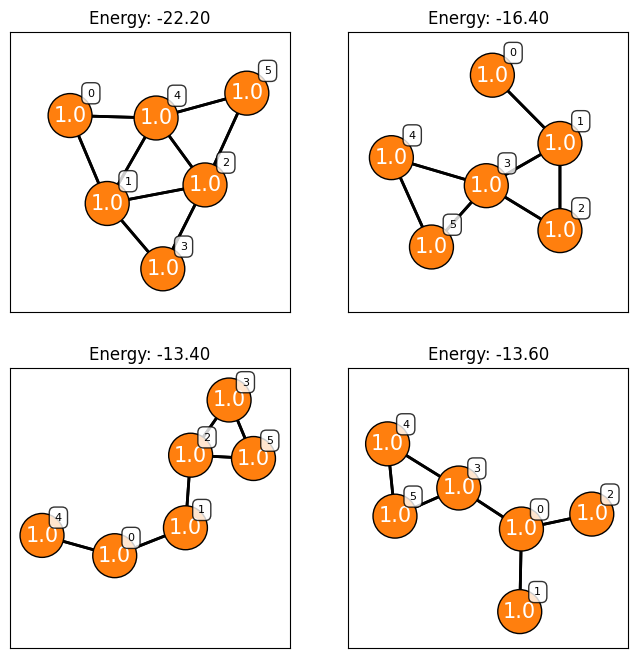

In [175]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
graphs = 10 * np.arange(4)
for ax, index in zip(axs.flatten(), graphs):
    draw_graph(get_graph(index), ax)
    ax.set_title(f'Energy: {data["energies"][index]:.2f}',)

save_plot(fig, 'Graphs, initial.png')

In [176]:
all_graphs = [get_graph(i) for i in range(len(data['energies']))]
print(all_graphs[0])

Data(x=[6, 1], edge_index=[2, 18], y=-22.200000762939453, pos=[6, 2])


In [177]:
aggr_phi_psi_gnn = AggrPhiPsiGNN(1, 1)
model_aggr = lambda graph: aggr_phi_psi_gnn(graph.x, graph.edge_index, graph.batch)



In [178]:

global_loader = DataLoader(all_graphs, batch_size=2, shuffle=True)

epochs = 1
optimizer = torch.optim.Adam(aggr_phi_psi_gnn.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_aggr(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

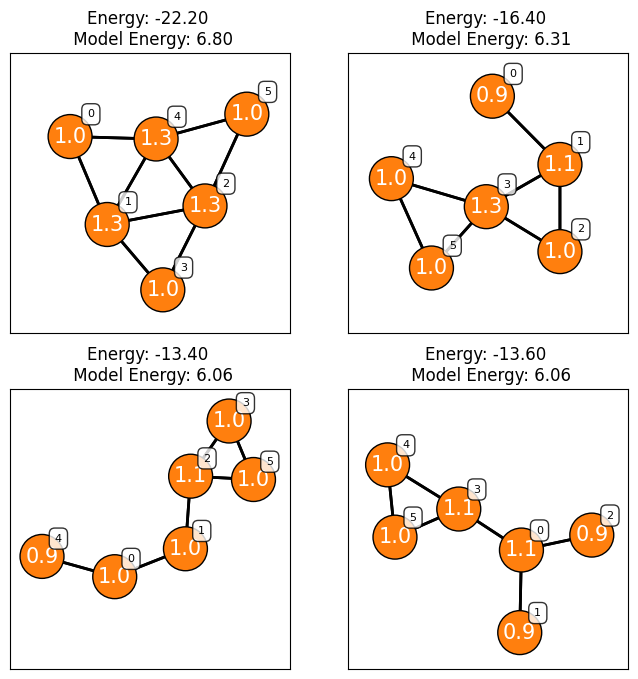

In [179]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
graphs = 10 * np.arange(4)
for ax, index in zip(axs.flatten(), graphs):
    graph = get_graph(index)
    model_energy = model_aggr(graph)[1].item()
    graph.x = model_aggr(graph)[0]
    draw_graph(graph, ax)
    
    ax.set_title(f'Energy: {data["energies"][index]:.2f} \n Model Energy: {model_energy:.2f}' ,)


#save_plot(fig, 'Graphs, OneMessage.png')

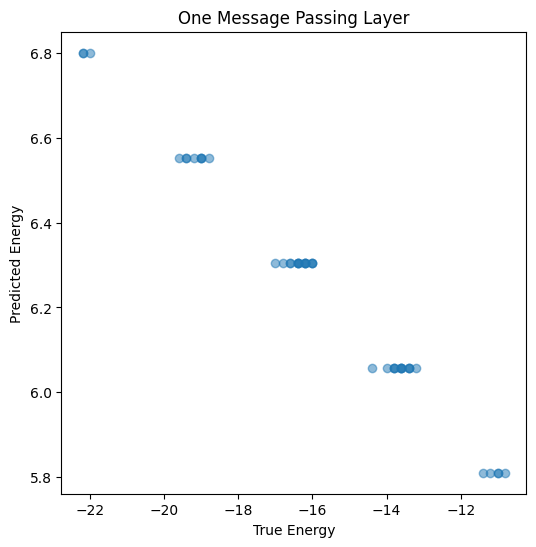

In [180]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for graph in all_graphs:
    ax.scatter(graph.y.item(), model_aggr(graph)[1].item(), color='tab:blue', alpha=0.5)
    ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='One Message Passing Layer')


#save_plot(fig, 'Parity, OneMessage.png')

# Two Message Passing Layers

In [181]:
class TwoMessagePassingGNN(torch.nn.Module):

    def __init__(self, mes1 = 1, hid1 = 1, mes2 = 1):
        super().__init__()
        self.layer1 = PhiPsiGNN(1, mes1, hid1)
        self.layer2 = PhiPsiGNN(hid1, mes2, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = x.view(-1,1)
    
        y = self.aggr(x, graph.batch)
        x = x.flatten()
        return x, y


    def representation(self, graph):
        x = self.layer1(graph.x, graph.edge_index)
        x = x.view(-1,1)
        x = self.layer2(x, graph.edge_index)
        return x

In [182]:
TwoMessageGNN = TwoMessagePassingGNN(1, 1, 1)
model_two_message= lambda graph: TwoMessageGNN.forward(graph)

In [183]:

global_loader = DataLoader(all_graphs, batch_size=2, shuffle=True)

epochs = 1000
optimizer = torch.optim.Adam(TwoMessageGNN.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_two_message(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 250/1000, Loss: 0.0058
Epoch 500/1000, Loss: 0.0017
Epoch 750/1000, Loss: 0.0003
Epoch 1000/1000, Loss: 0.0000


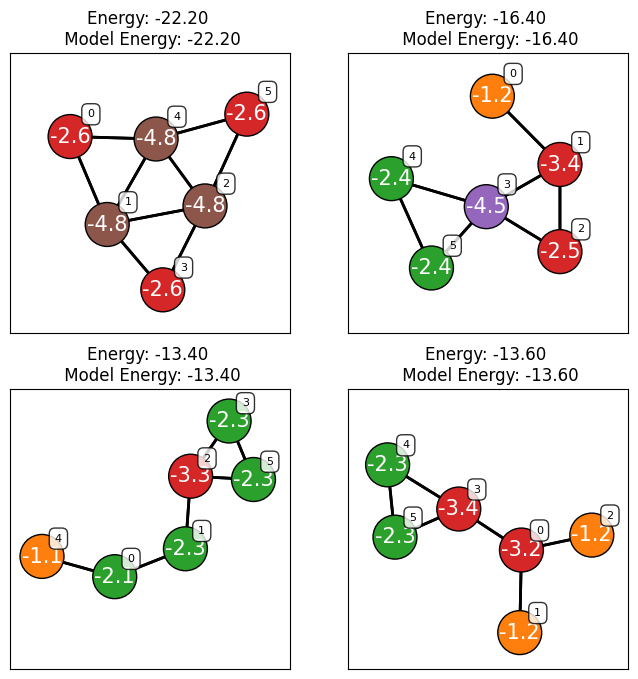

In [184]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
graphs = 10 * np.arange(4)
for ax, index in zip(axs.flatten(), graphs):
    graph = get_graph(index)
    model_energy = model_two_message(graph)[1].item()
    graph.x = model_two_message(graph)[0]
    draw_graph(graph, ax)
    
    ax.set_title(f'Energy: {data["energies"][index]:.2f} \n Model Energy: {model_energy:.2f}' ,)


#save_plot(fig, 'Graphs, TwoMessage.png')

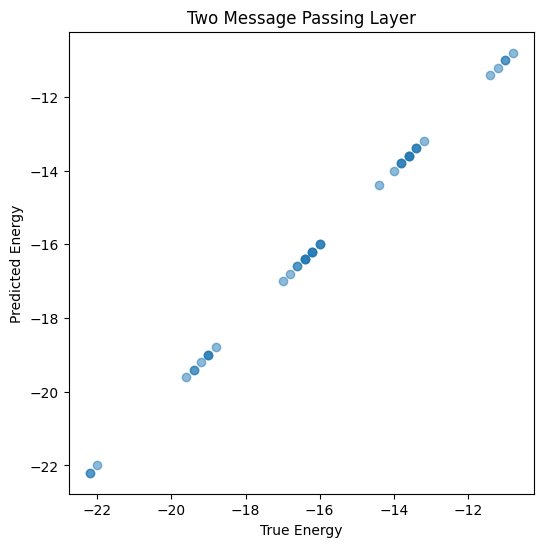

In [185]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

for graph in all_graphs:
    ax.scatter(graph.y.item(), model_two_message(graph)[1].item(), color='tab:blue', alpha=0.5)
    ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='Two Message Passing Layer')


#save_plot(fig, 'Parity, TwoMessage.png')

In [186]:
MODIFIED = True
if MODIFIED:
    data = np.load('dataset_for_exercise_62/modified_tb_clusters_6.npz')
else:
    data = np.load('dataset_for_exercise_62/tight_binding_clusters_6.npz')

In [187]:
all_graphs = [get_graph(i) for i in range(len(data['energies']))]
test_idxs = [23, 36, 21, 19, 9, 39, 42, 3, 0]
test_graphs = [all_graphs[i] for i in test_idxs]
train_graphs = [all_graphs[i] for i in range(len(all_graphs)) if i not in test_idxs]

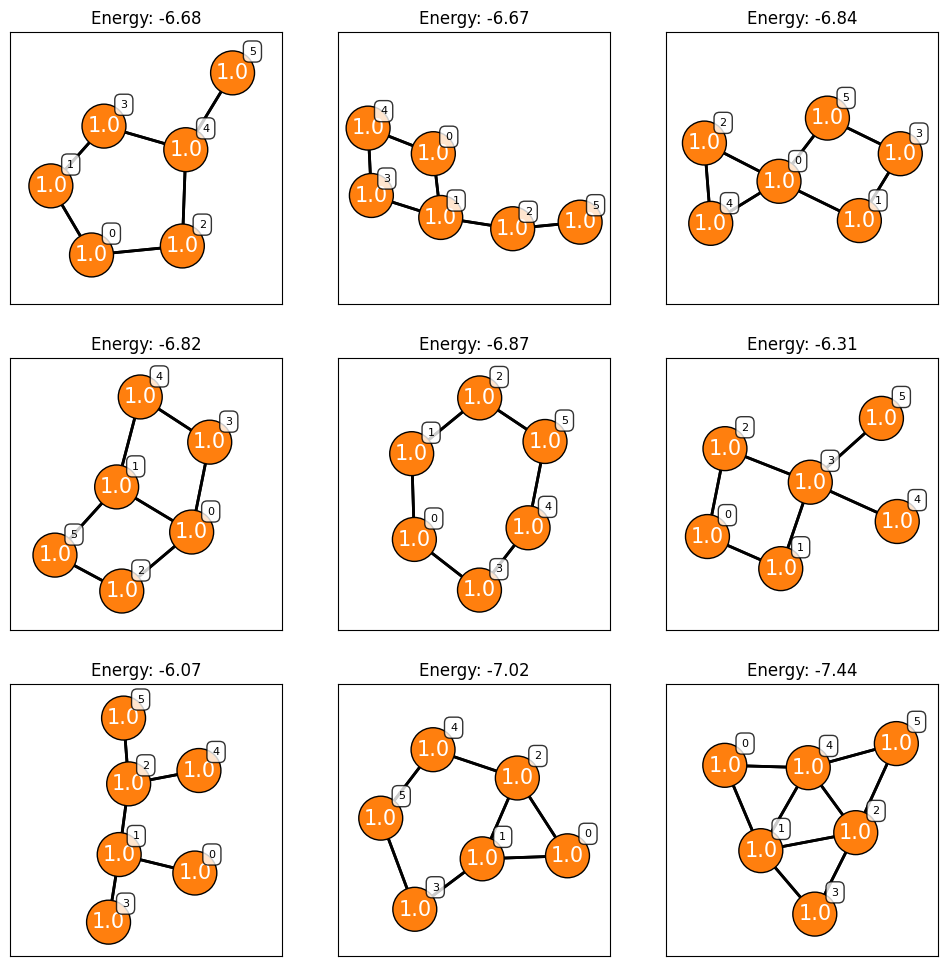

In [188]:

fig, axs = plt.subplots(3,3, figsize=(12,12))

for ax, graph in zip(axs.flatten(), test_graphs):
    draw_graph(graph, ax)
    ax.set_title(f'Energy: {graph.y.item():.2f}')


In [189]:
TwoMessageGNN = TwoMessagePassingGNN(1, 1, 1)
model_two_message= lambda graph: TwoMessageGNN.forward(graph)

In [190]:

global_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

epochs = 1000
optimizer = torch.optim.Adam(TwoMessageGNN.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_two_message(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 250/1000, Loss: 0.0421
Epoch 500/1000, Loss: 0.0276
Epoch 750/1000, Loss: 0.0255
Epoch 1000/1000, Loss: 0.0255


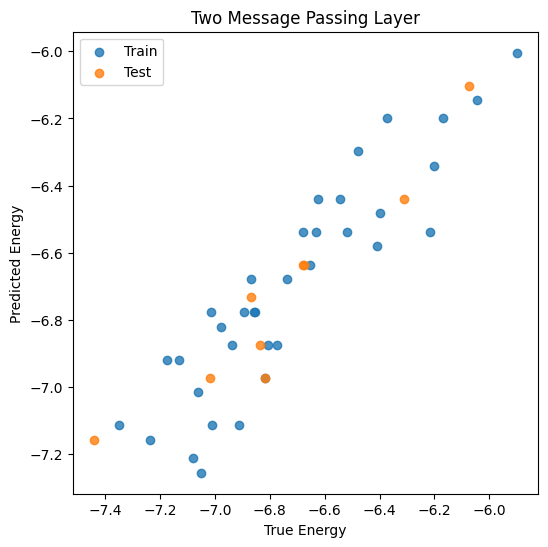

In [191]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

test_energies = [graph.y.item() for graph in test_graphs]
model_test_energies = [model_two_message(graph)[1].item() for graph in test_graphs]

train_energies = [graph.y.item() for graph in train_graphs]
model_train_energies = [model_two_message(graph)[1].item() for graph in train_graphs]

ax.scatter(train_energies, model_train_energies, color='tab:blue', alpha=0.8, label='Train')
ax.scatter(test_energies, model_test_energies, color='tab:orange', alpha=0.8, label='Test')
ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='Two Message Passing Layer')

ax.legend()

save_plot(fig, f'Parity, TwoMessage, Mod: {str(MODIFIED)}.png')

In [192]:
class FourMessagePassingGNN(torch.nn.Module):

    def __init__(self, mes1 = 1, hid1 = 1, mes2 = 1, hid2 = 1, mes3 = 1, hid3 = 1, mes4 = 1):
        super().__init__()
        self.layer1 = PhiPsiGNN(1, mes1, hid1)
        self.layer2 = PhiPsiGNN(hid1, mes2, hid2)
        self.layer3 = PhiPsiGNN(hid2, mes3, hid3)
        self.layer4 = PhiPsiGNN(hid3, mes4, 1)
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = x.view(-1,1)
    
        y = self.aggr(x, graph.batch)
        x = x.flatten()
        return x, y


    def representation(self, graph):
        x = self.layer1(graph.x, graph.edge_index)
        x = x.view(-1,1)
        x = self.layer2(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.layer3(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.layer4(x, graph.edge_index)
        return x

In [193]:
FourMessageGNN = FourMessagePassingGNN()
model_four_message= lambda graph: FourMessageGNN.forward(graph)



In [194]:

global_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

epochs = 1000
optimizer = torch.optim.Adam(FourMessageGNN.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_four_message(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 250/1000, Loss: 0.0354
Epoch 500/1000, Loss: 0.0206
Epoch 750/1000, Loss: 0.0205
Epoch 1000/1000, Loss: 0.0199


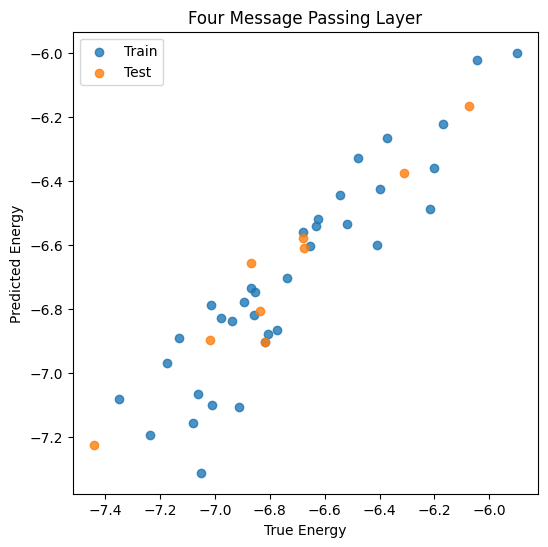

In [195]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

test_energies = [graph.y.item() for graph in test_graphs]
model_test_energies = [model_four_message(graph)[1].item() for graph in test_graphs]

train_energies = [graph.y.item() for graph in train_graphs]
model_train_energies = [model_four_message(graph)[1].item() for graph in train_graphs]

ax.scatter(train_energies, model_train_energies, color='tab:blue', alpha=0.8, label='Train')
ax.scatter(test_energies, model_test_energies, color='tab:orange', alpha=0.8, label='Test')
ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='Four Message Passing Layer')

ax.legend()

save_plot(fig, f'Parity, FourMessage, Mod: {str(MODIFIED)}.png')

In [196]:
class ActFourMessagePassingGNN(torch.nn.Module):

    def __init__(self, mes1 = 1, hid1 = 1, mes2 = 1, hid2 = 1, mes3 = 1, hid3 = 1, mes4 = 1, activation_function = torch.nn.ReLU()):
        super().__init__()
        self.layer1 = PhiPsiGNN(1, mes1, hid1)
        self.layer2 = PhiPsiGNN(hid1, mes2, hid2)
        self.layer3 = PhiPsiGNN(hid2, mes3, hid3)
        self.layer4 = PhiPsiGNN(hid3, mes4, 1)
        self.activation = activation_function
        self.aggr = SumAggregation()

    def forward(self, graph):
        x = self.representation(graph)
        x = x.view(-1,1)
    
        y = self.aggr(x, graph.batch)
        x = x.flatten()
        return x, y


    def representation(self, graph):
        x = self.layer1(graph.x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer2(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer3(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer4(x, graph.edge_index)
        x = x.view(-1,1)
        #x = self.activation(x)
        return x

In [197]:
ActFourMessageGNN = ActFourMessagePassingGNN(activation_function=torch.nn.SiLU())
model_Act_four_message= lambda graph: ActFourMessageGNN.forward(graph)

model_Act_four_message(get_graph(0))

(tensor([0.2977, 0.4562, 0.4562, 0.2977, 0.4562, 0.2977],
        grad_fn=<ViewBackward0>),
 tensor([[2.2618]], grad_fn=<ScatterAddBackward0>))

In [198]:

global_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

epochs = 2000
optimizer = torch.optim.Adam(ActFourMessageGNN.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_Act_four_message(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 250/2000, Loss: 0.0296
Epoch 500/2000, Loss: 0.0255
Epoch 750/2000, Loss: 0.0236
Epoch 1000/2000, Loss: 0.0229
Epoch 1250/2000, Loss: 0.0230
Epoch 1500/2000, Loss: 0.0223
Epoch 1750/2000, Loss: 0.0211
Epoch 2000/2000, Loss: 0.0211


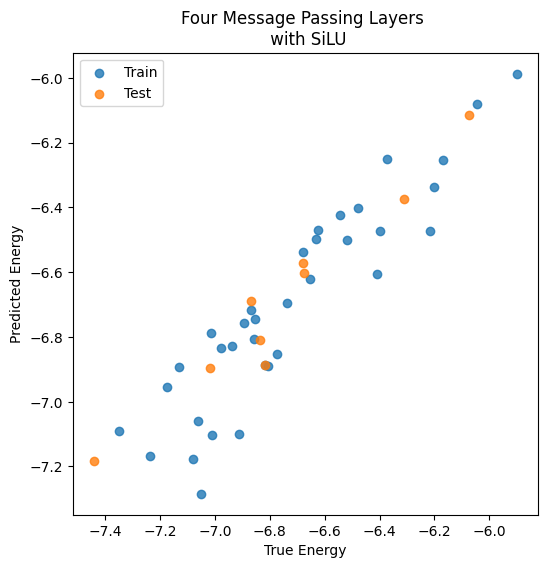

In [199]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

test_energies = [graph.y.item() for graph in test_graphs]
model_test_energies = [model_Act_four_message(graph)[1].item() for graph in test_graphs]

train_energies = [graph.y.item() for graph in train_graphs]
model_train_energies = [model_Act_four_message(graph)[1].item() for graph in train_graphs]

ax.scatter(train_energies, model_train_energies, color='tab:blue', alpha=0.8, label='Train')
ax.scatter(test_energies, model_test_energies, color='tab:orange', alpha=0.8, label='Test')
ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='Four Message Passing Layers \n with SiLU')

ax.legend()

save_plot(fig, f'Parity, ActFourMessage, Mod: {str(MODIFIED)}.png')

In [200]:
class HeadActFourMessagePassingGNN(torch.nn.Module):

    def __init__(self, mes1 = 1, hid1 = 1, mes2 = 1, hid2 = 1, mes3 = 1, hid3 = 1, mes4 = 1, activation_function = torch.nn.ReLU(), hidden = 8):
        super().__init__()
        self.layer1 = PhiPsiGNN(1, mes1, hid1)
        self.layer2 = PhiPsiGNN(hid1, mes2, hid2)
        self.layer3 = PhiPsiGNN(hid2, mes3, hid3)
        self.layer4 = PhiPsiGNN(hid3, mes4, 1)
        self.activation = activation_function
        self.aggr = SumAggregation()
        self.fc1 = torch.nn.Linear(1, hidden)
        self.fc2 = torch.nn.Linear(hidden, 1)

    def forward(self, graph):
        local_energies = self.local_energies(graph)

        global_energy = self.aggr(local_energies, graph.batch)
        local_energies = local_energies.flatten()
        return local_energies, global_energy


    def representation(self, graph):
        x = self.layer1(graph.x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer2(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer3(x, graph.edge_index)
        x = x.view(-1,1)
        x = self.activation(x)
        x = self.layer4(x, graph.edge_index)
        x = x.view(-1,1)
        #x = self.activation(x)
        return x

    def local_energies(self, graph):
        x = self.representation(graph)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [201]:
HeadActFourMessageGNN = HeadActFourMessagePassingGNN(activation_function=torch.nn.SiLU())
model_head_Act_four_message= lambda graph: HeadActFourMessageGNN.forward(graph)

model_head_Act_four_message(get_graph(0))

(tensor([-0.0736, -0.0266, -0.0266, -0.0736, -0.0266, -0.0736],
        grad_fn=<ViewBackward0>),
 tensor([[-0.3007]], grad_fn=<ScatterAddBackward0>))

In [202]:

global_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

epochs = 3000
optimizer = torch.optim.Adam(HeadActFourMessageGNN.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    total_loss = 0
    total_N = 0
    for graphs in global_loader:
        optimizer.zero_grad()
        prediction = model_head_Act_four_message(graphs)[1]
        loss = criterion(prediction.flatten(), graphs.y)
        loss.backward()
        optimizer.step()

        N = len(graphs)
        total_N += N
        total_loss += loss.item() * N

    avg_loss = total_loss / total_N
    if (epoch+1) % 250 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')


Epoch 250/3000, Loss: 0.0437
Epoch 500/3000, Loss: 0.0291
Epoch 750/3000, Loss: 0.0245
Epoch 1000/3000, Loss: 0.0230
Epoch 1250/3000, Loss: 0.0236
Epoch 1500/3000, Loss: 0.0311
Epoch 1750/3000, Loss: 0.0221
Epoch 2000/3000, Loss: 0.0247
Epoch 2250/3000, Loss: 0.0200
Epoch 2500/3000, Loss: 0.0204
Epoch 2750/3000, Loss: 0.0198
Epoch 3000/3000, Loss: 0.0161


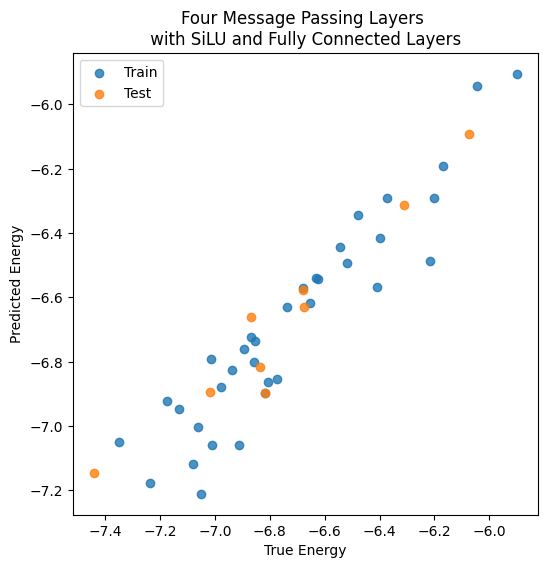

In [203]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

test_energies = [graph.y.item() for graph in test_graphs]
model_test_energies = [model_head_Act_four_message(graph)[1].item() for graph in test_graphs]

train_energies = [graph.y.item() for graph in train_graphs]
model_train_energies = [model_head_Act_four_message(graph)[1].item() for graph in train_graphs]

ax.scatter(train_energies, model_train_energies, color='tab:blue', alpha=0.8, label='Train')
ax.scatter(test_energies, model_test_energies, color='tab:orange', alpha=0.8, label='Test')
ax.set(xlabel='True Energy', ylabel='Predicted Energy', title='Four Message Passing Layers \n with SiLU and Fully Connected Layers ')

ax.legend()

save_plot(fig, f'Parity, HeadActFourMessage, Mod: {str(MODIFIED)}.png')